# `median()` for a dask-backed xarray

Runs a median on an dask-backed xarray. Based on the [gist](https://gist.github.com/andrewdhicks/d89849997453cdfad6fa568816ca7160) by Andrew Hicks.
    
It will rechunk along the given dimension, so make sure your other chunk sizes are small enough that it will fit into memory.

In [1]:
%matplotlib inline
import dask.array
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def median(array, dim, keep_attrs=False, skipna=False, **kwargs):
    """ Runs a median on an dask-backed xarray.
    
    This function does not scale!
    It will rechunk along the given dimension, so make sure 
    your other chunk sizes are small enough that it 
    will fit into memory.
    
    :param array: An xarray.DataArray wrapping a dask array
    :type array: xarray.DataArray
    :param dim: The name of the dim in array to calculate the median
    :type dim: str
    """
    if type(array) is xr.Dataset:
        return array.apply(median, dim=dim, keep_attrs=keep_attrs, **kwargs)
    
    if not hasattr(array.data, 'dask'):
        return array.median(dim, keep_attrs=keep_attrs, **kwargs)
    
    array = array.chunk({dim:-1})
    axis = array.dims.index(dim)
    median_func = np.nanmedian if skipna else np.median
    blocks = dask.array.map_blocks(median_func, array.data, dtype=array.dtype, drop_axis=axis, axis=axis, **kwargs)
    
    new_coords={k: v for k, v in array.coords.items() if k != dim and dim not in v.dims}
    new_dims = tuple(d for d in array.dims if d != dim)
    new_attrs = array.attrs if keep_attrs else None
    
    return xr.DataArray(blocks, coords=new_coords, dims=new_dims, attrs=new_attrs)

In [3]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB


## Let's try it out

In [4]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data

dc = Datacube()

In [5]:
platform = 'LANDSAT_8'

product = 'ls8_usgs_sr_scene'
measurements = ['red', 'green', 'blue', 'pixel_qa']

output_crs = 'EPSG:3460'
resolution = (-30, 30)

In [6]:
# Sub-region selection - e.g. Viti Levu
#latitude = (-18.2962, -17.2867)
#longitude = (177.1594, 178.7222)

# Sub-region selection - e.g. Viti Levu's eastern coast
#latitude = (-18.0438, -17.5391)
#longitude = (178.3315, 178.7222)

# Sub-region selection - e.g. the city of Suva
latitude = (-18.2316, -18.0516)
longitude = (178.2819, 178.6019)

time_extents = ('2017-01-01', '2019-06-01')

In [7]:
landsat_dataset = dc.load(
    product=product,
    time=time_extents,
    lat=latitude,
    lon=longitude,
    output_crs=output_crs,
    resolution=resolution,
    measurements = measurements,
    group_by='solar_day',
    dask_chunks={
        'time': 1,
        'x': 500,
        'y': 500,
    }
)
landsat_dataset

<xarray.Dataset>
Dimensions:   (time: 90, x: 1130, y: 667)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2019-04-10T22:12:17.894022
  * y         (y) float64 3.884e+06 3.884e+06 3.884e+06 ... 3.864e+06 3.864e+06
  * x         (x) float64 1.95e+06 1.95e+06 1.95e+06 ... 1.984e+06 1.984e+06
Data variables:
    red       (time, y, x) int16 dask.array<shape=(90, 667, 1130), chunksize=(1, 500, 500)>
    green     (time, y, x) int16 dask.array<shape=(90, 667, 1130), chunksize=(1, 500, 500)>
    blue      (time, y, x) int16 dask.array<shape=(90, 667, 1130), chunksize=(1, 500, 500)>
    pixel_qa  (time, y, x) uint16 dask.array<shape=(90, 667, 1130), chunksize=(1, 500, 500)>
Attributes:
    crs:      EPSG:3460

In [8]:
print("Up to {:2.1f} billion pixels might be involved".format((len(landsat_dataset.x) * len(landsat_dataset.y) * len(landsat_dataset.time)) / 1e9))

Up to 0.1 billion pixels might be involved


In [9]:
# Identify pixels with valid data
good_quality = (
    (landsat_dataset.pixel_qa == 322)  | # clear
    (landsat_dataset.pixel_qa == 386)  |
    (landsat_dataset.pixel_qa == 834)  |
    (landsat_dataset.pixel_qa == 898)  |
    (landsat_dataset.pixel_qa == 1346) |
    (landsat_dataset.pixel_qa == 324)  | # water
    (landsat_dataset.pixel_qa == 388)  |
    (landsat_dataset.pixel_qa == 836)  |
    (landsat_dataset.pixel_qa == 900)  |
    (landsat_dataset.pixel_qa == 1348)
)

# Apply mask
landsat_dataset = landsat_dataset.where(good_quality)

In [15]:
red_nanmedian   = median(landsat_dataset.red,   dim='time', skipna=True)
green_nanmedian = median(landsat_dataset.green, dim='time', skipna=True)
blue_nanmedian  = median(landsat_dataset.blue,  dim='time', skipna=True)

NameError: name 'landsat_dataset' is not defined

In [11]:
#plt.figure()
#im = red_nanmedian.compute().plot.imshow()
#plt.axis('equal')
#plt.show()

In [12]:
%%time
#median_composite = np.dstack([red_nanmedian, green_nanmedian, blue_nanmedian])
median_composite = np.stack([red_nanmedian, green_nanmedian, blue_nanmedian], axis=-1)
median_composite /= (np.nanmax(median_composite) / 2.5)

CPU times: user 3.79 s, sys: 401 ms, total: 4.19 s
Wall time: 1min 8s


In [14]:
del landsat_dataset

NameError: name 'landsat_dataset' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


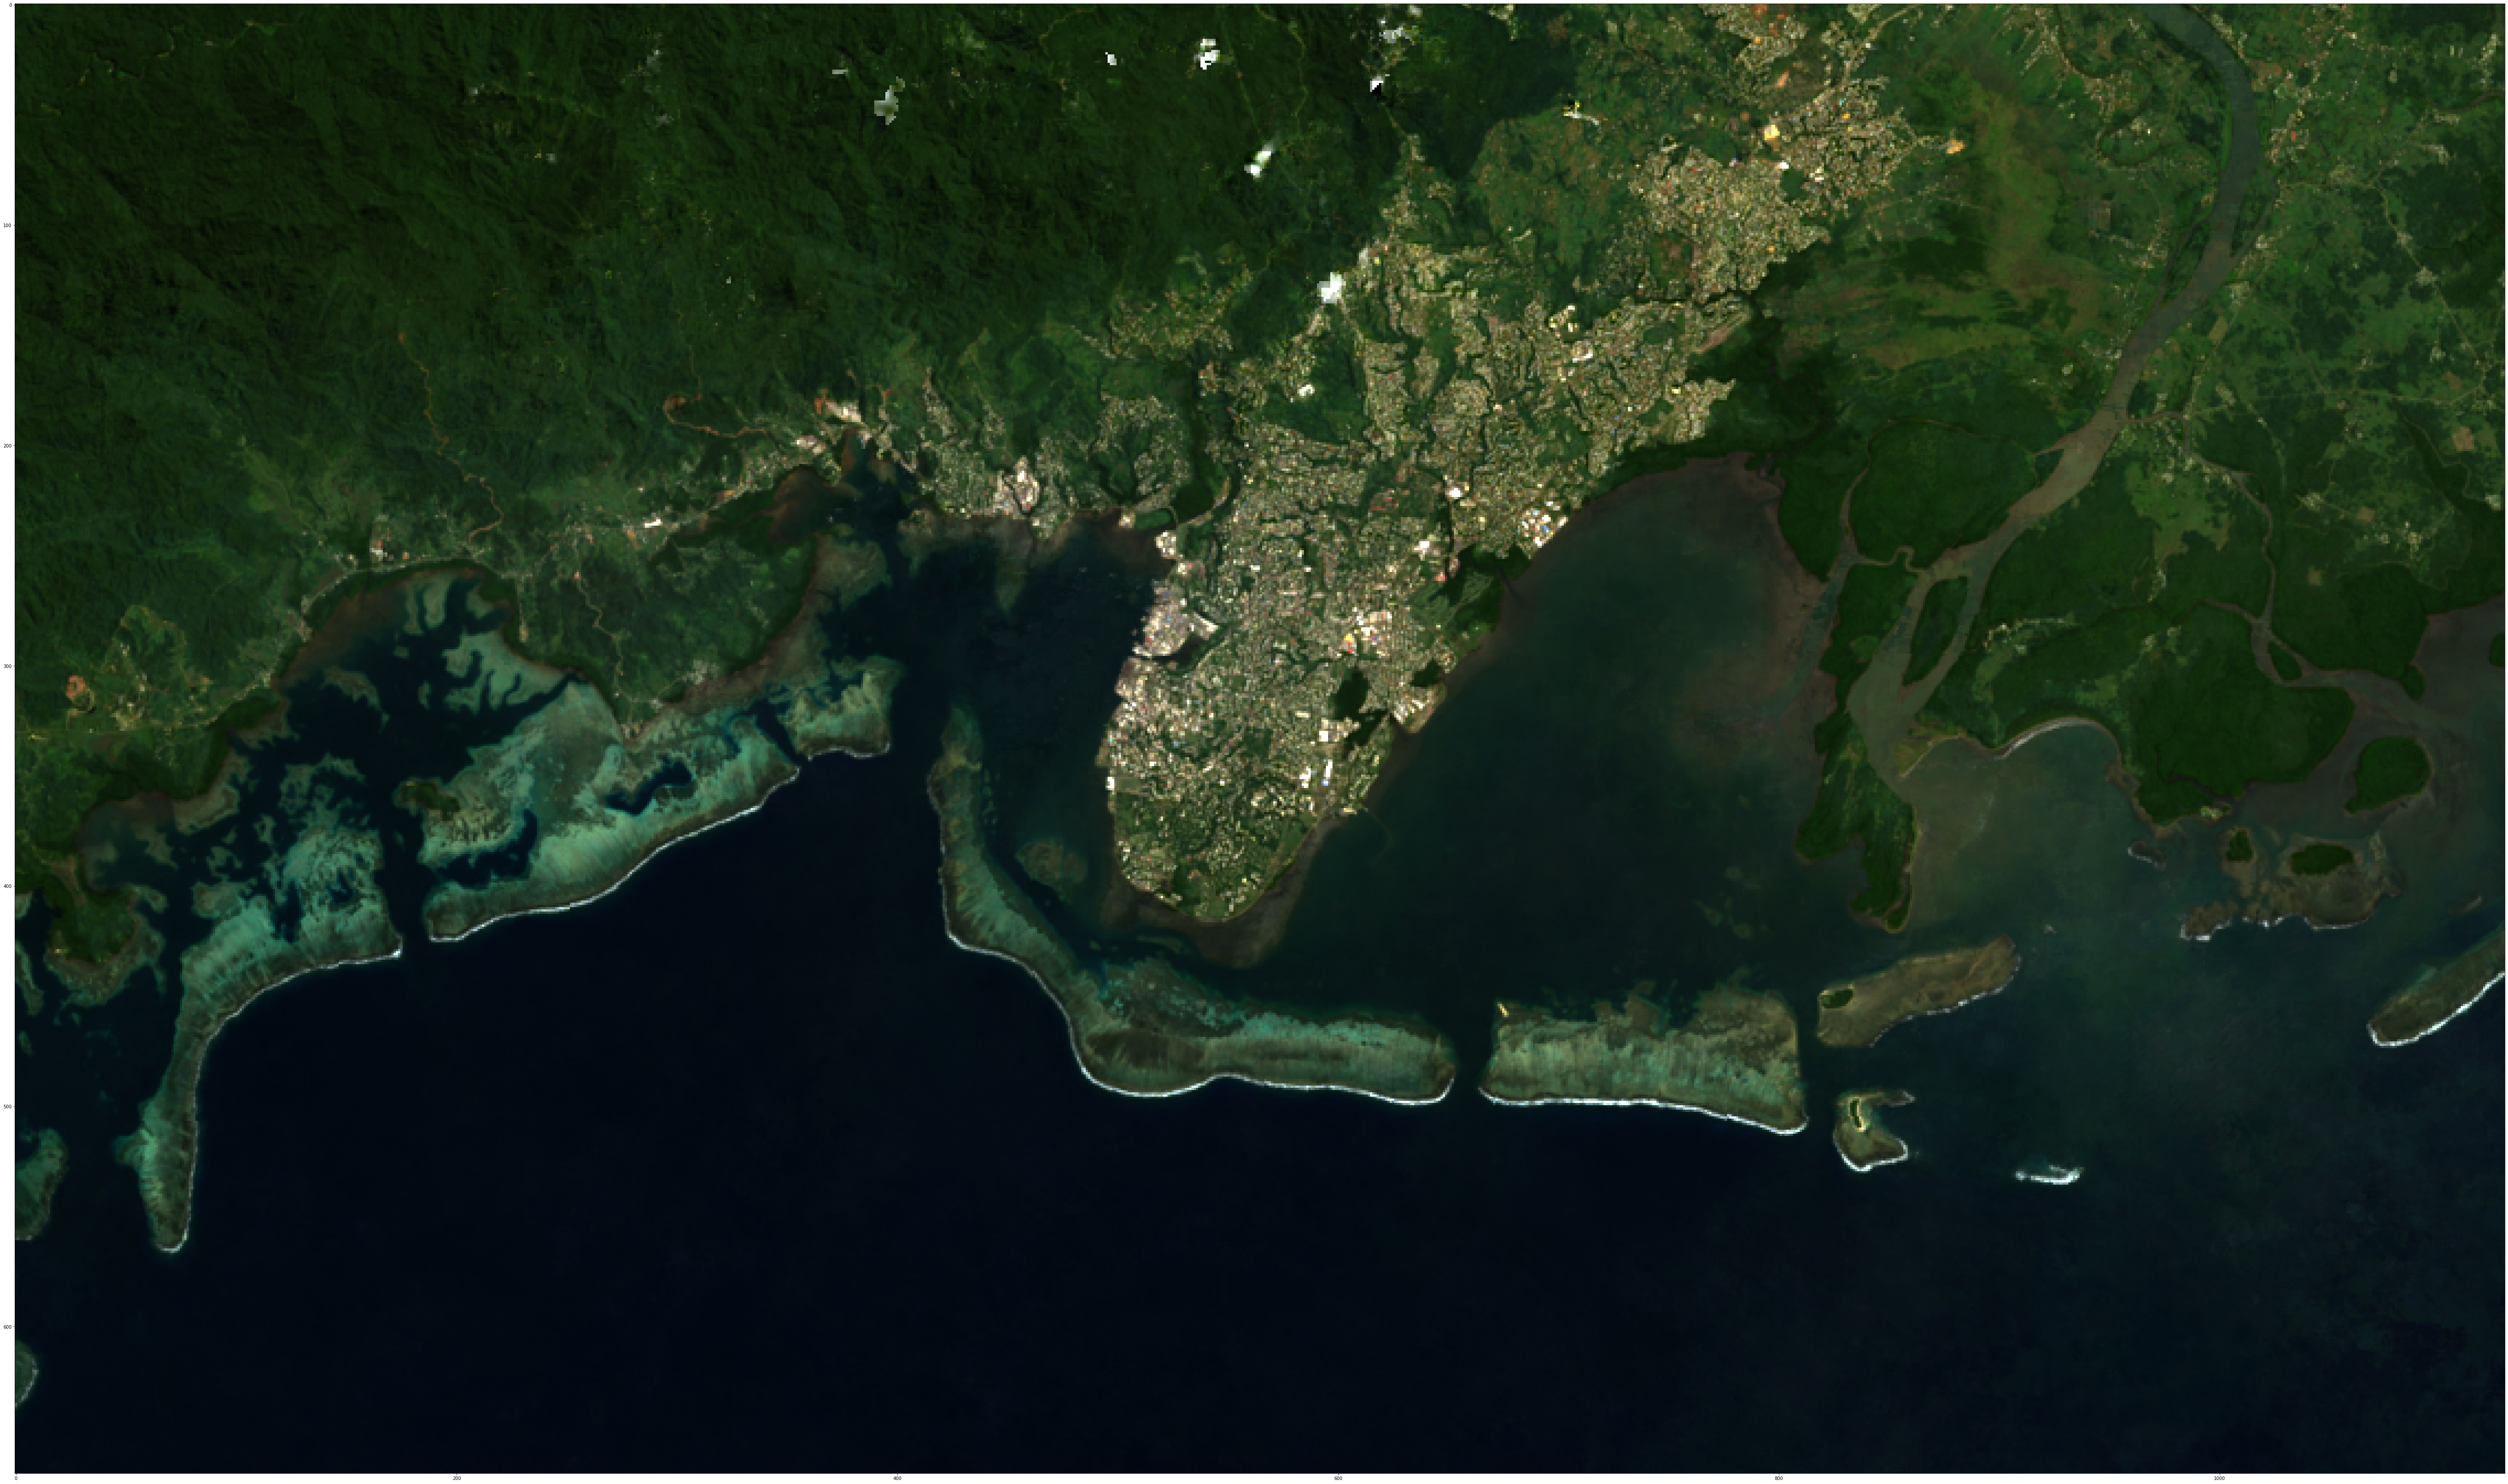

In [16]:
fig, ax = plt.subplots(figsize=(100, 100))
ax.imshow(median_composite)

In [15]:
client.restart()

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 40 Memory: 168.65 GB
